In [1]:
# Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Load the data from the CSV file
price_data = pd.read_csv('./data/CCL_historical_data.csv')
price_data

,datetime,o,h,l,c,v,readable_time
0,1569830400000,43.81,43.81,43.46,43.48,700,2019-09-30 03:00:00
1,1569832200000,43.30,43.30,43.30,43.30,300,2019-09-30 03:30:00
2,1569834000000,43.51,43.51,43.50,43.50,252,2019-09-30 04:00:00
3,1569837600000,43.51,43.51,43.50,43.50,300,2019-09-30 05:00:00
4,1569841200000,43.81,43.81,43.81,43.81,300,2019-09-30 06:00:00
...,...,...,...,...,...,...,...
4631,1591997400000,19.77,19.79,19.65,19.65,62906,2020-06-12 16:30:00
4632,1591999200000,19.65,19.77,19.60,19.73,26396,2020-06-12 17:00:00
4633,1592001000000,19.70,19.79,19.67,19.73,25103,2020-06-12 17:30:00
4634,1592002800000,19.73,19.90,19.72,19.90,44131,2020-06-12 18:00:00


In [3]:
# Add a "Change in price" column
price_data['change_in_price'] = price_data['c'].diff()

In [4]:
price_data.head()

,datetime,o,h,l,c,v,readable_time,change_in_price
0,1569830400000,43.81,43.81,43.46,43.48,700,2019-09-30 03:00:00,NaN
1,1569832200000,43.30,43.30,43.30,43.30,300,2019-09-30 03:30:00,-0.18
2,1569834000000,43.51,43.51,43.50,43.50,252,2019-09-30 04:00:00,0.20
3,1569837600000,43.51,43.51,43.50,43.50,300,2019-09-30 05:00:00,0.00
4,1569841200000,43.81,43.81,43.81,43.81,300,2019-09-30 06:00:00,0.31


In [5]:
# Let's smooth out the data to remove some randomness and noise

# Define the number of frequency intervals you want to predict (in this case, 1 minute)
interval_out = 25 # So roughly 1 day out

# Grou p by symbol, then apply the rolling function and grab the min/max
price_data_smoothed = price_data[['c','l','h','o','v']].transform(lambda x: x.ewm(span = interval_out).mean())
    
smoothed_df = pd.concat([price_data[['datetime','readable_time']], price_data_smoothed], axis = 1, sort=False)
smoothed_df

,datetime,readable_time,c,l,h,o,v
0,1569830400000,2019-09-30 03:00:00,43.480000,43.460000,43.810000,43.810000,7.000000e+02
1,1569832200000,2019-09-30 03:30:00,43.386400,43.376800,43.544800,43.544800,4.920000e+02
2,1569834000000,2019-09-30 04:00:00,43.427335,43.421194,43.532260,43.532260,4.055181e+02
3,1569837600000,2019-09-30 05:00:00,43.447737,43.443320,43.526010,43.526010,3.758921e+02
4,1569841200000,2019-09-30 06:00:00,43.532226,43.528839,43.592244,43.592244,3.581922e+02
...,...,...,...,...,...,...,...
4631,1591997400000,2020-06-12 16:30:00,19.389961,19.164282,19.582007,19.371606,2.112672e+06
4632,1591999200000,2020-06-12 17:00:00,19.416118,19.197798,19.596468,19.393021,1.952189e+06
4633,1592001000000,2020-06-12 17:30:00,19.440263,19.234122,19.611355,19.416635,1.803951e+06
4634,1592002800000,2020-06-12 18:00:00,19.475627,19.271497,19.633558,19.440740,1.668581e+06


In [6]:
smoothed_df['Signal_Flag'] = smoothed_df['datetime'].transform(lambda x: np.sign(x.diff(interval_out)))

smoothed_df.head(50)

,datetime,readable_time,c,l,h,o,v,Signal_Flag
0,1569830400000,2019-09-30 03:00:00,43.480000,43.460000,43.810000,43.810000,700.000000,NaN
1,1569832200000,2019-09-30 03:30:00,43.386400,43.376800,43.544800,43.544800,492.000000,NaN
2,1569834000000,2019-09-30 04:00:00,43.427335,43.421194,43.532260,43.532260,405.518124,NaN
3,1569837600000,2019-09-30 05:00:00,43.447737,43.443320,43.526010,43.526010,375.892141,NaN
4,1569841200000,2019-09-30 06:00:00,43.532226,43.528839,43.592244,43.592244,358.192175,NaN
5,1569844800000,2019-09-30 07:00:00,43.586236,43.583532,43.644233,43.640199,850.702953,NaN
6,1569846600000,2019-09-30 07:30:00,43.633517,43.613384,43.681114,43.659889,997.084516,NaN
7,1569848400000,2019-09-30 08:00:00,43.675238,43.638860,43.715093,43.677800,1314.108147,NaN
8,1569850200000,2019-09-30 08:30:00,43.656475,43.620303,43.775756,43.697607,53073.491370,NaN
9,1569852000000,2019-09-30 09:00:00,43.657665,43.606297,43.765876,43.676296,72686.288569,NaN


In [7]:
# Calculate the 25 interval(30 minute) RSI (so roughly 1 day)
n = 25
up_df, down_df = price_data[['datetime','change_in_price']].copy(), price_data[['datetime','change_in_price']].copy()

up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We can obly have positive values so change negative down days to their absolute value
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EQMA (Exponential Weighted Moving Average), meaning older values are given less weight compared
#  new values
ewma_up = up_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# # Calculate Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate Relative Strength Index (RSI)
relative_strength_index = 100.0 - (100 / (1.0 + relative_strength))

# Add data into the data frame
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = down_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.head()

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI
0,1569830400000,43.81,43.81,43.46,43.48,700,2019-09-30 03:00:00,NaN,NaN,NaN,NaN
1,1569832200000,43.30,43.30,43.30,43.30,300,2019-09-30 03:30:00,-0.18,0.18,0.18,0.000000
2,1569834000000,43.51,43.51,43.50,43.50,252,2019-09-30 04:00:00,0.20,0.00,0.00,54.621849
3,1569837600000,43.51,43.51,43.50,43.50,300,2019-09-30 05:00:00,0.00,0.00,0.00,54.621849
4,1569841200000,43.81,43.81,43.81,43.81,300,2019-09-30 06:00:00,0.31,0.00,0.00,77.238366


In [8]:
# Stochastic Oscillator

n = 25

low_25, high_25 = price_data[['datetime', 'l']].copy(), price_data[['datetime', 'h']].copy()

low_25 = low_25['l'].transform(lambda x: x.rolling(window = n).min())
high_25 = high_25['h'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator
k_percent = 100 * ((price_data['c'] - 14) / (high_25 - low_25))

# Add the info to the data frame
price_data['low_14'] = low_25
price_data['high_14'] = high_25
price_data['k_percent'] = k_percent

price_data.head(30)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
0,1569830400000,43.810,43.8100,43.460,43.4800,700,2019-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1569832200000,43.300,43.3000,43.300,43.3000,300,2019-09-30 03:30:00,-0.1800,0.1800,0.1800,0.000000,NaN,NaN,NaN
2,1569834000000,43.510,43.5100,43.500,43.5000,252,2019-09-30 04:00:00,0.2000,0.0000,0.0000,54.621849,NaN,NaN,NaN
3,1569837600000,43.510,43.5100,43.500,43.5000,300,2019-09-30 05:00:00,0.0000,0.0000,0.0000,54.621849,NaN,NaN,NaN
4,1569841200000,43.810,43.8100,43.810,43.8100,300,2019-09-30 06:00:00,0.3100,0.0000,0.0000,77.238366,NaN,NaN,NaN
5,1569844800000,43.830,43.8500,43.800,43.8000,2800,2019-09-30 07:00:00,-0.0100,0.0100,0.0100,75.916117,NaN,NaN,NaN
6,1569846600000,43.750,43.8499,43.750,43.8499,1667,2019-09-30 07:30:00,0.0499,0.0000,0.0000,77.956121,NaN,NaN,NaN
7,1569848400000,43.770,43.8900,43.770,43.8900,2946,2019-09-30 08:00:00,0.0401,0.0000,0.0000,79.470026,NaN,NaN,NaN
8,1569850200000,43.810,44.1200,43.515,43.5500,346790,2019-09-30 08:30:00,-0.3400,0.3400,0.3400,48.730019,NaN,NaN,NaN
9,1569852000000,43.545,43.7050,43.520,43.6650,193525,2019-09-30 09:00:00,0.1150,0.0000,0.0000,55.094733,NaN,NaN,NaN


In [9]:
# Calculate the Willams %R
n = 25


low_25, high_25 = price_data[['datetime', 'l']].copy(), price_data[['datetime', 'h']].copy()

low_25 = low_25['l'].transform(lambda x: x.rolling(window = n).min())
high_25 = high_25['h'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R
r_percent = ((high_25 - price_data['c']) / (high_25 - low_25)) * -100

price_data['r_percent'] = r_percent

price_data.head(30)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,1569830400000,43.810,43.8100,43.460,43.4800,700,2019-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1569832200000,43.300,43.3000,43.300,43.3000,300,2019-09-30 03:30:00,-0.1800,0.1800,0.1800,0.000000,NaN,NaN,NaN,NaN
2,1569834000000,43.510,43.5100,43.500,43.5000,252,2019-09-30 04:00:00,0.2000,0.0000,0.0000,54.621849,NaN,NaN,NaN,NaN
3,1569837600000,43.510,43.5100,43.500,43.5000,300,2019-09-30 05:00:00,0.0000,0.0000,0.0000,54.621849,NaN,NaN,NaN,NaN
4,1569841200000,43.810,43.8100,43.810,43.8100,300,2019-09-30 06:00:00,0.3100,0.0000,0.0000,77.238366,NaN,NaN,NaN,NaN
5,1569844800000,43.830,43.8500,43.800,43.8000,2800,2019-09-30 07:00:00,-0.0100,0.0100,0.0100,75.916117,NaN,NaN,NaN,NaN
6,1569846600000,43.750,43.8499,43.750,43.8499,1667,2019-09-30 07:30:00,0.0499,0.0000,0.0000,77.956121,NaN,NaN,NaN,NaN
7,1569848400000,43.770,43.8900,43.770,43.8900,2946,2019-09-30 08:00:00,0.0401,0.0000,0.0000,79.470026,NaN,NaN,NaN,NaN
8,1569850200000,43.810,44.1200,43.515,43.5500,346790,2019-09-30 08:30:00,-0.3400,0.3400,0.3400,48.730019,NaN,NaN,NaN,NaN
9,1569852000000,43.545,43.7050,43.520,43.6650,193525,2019-09-30 09:00:00,0.1150,0.0000,0.0000,55.094733,NaN,NaN,NaN,NaN


In [10]:
#  Calculate MACD 
ema_26 = price_data['c'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data['c'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data fram
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

price_data.head(30)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,1569830400000,43.810,43.8100,43.460,43.4800,700,2019-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,1569832200000,43.300,43.3000,43.300,43.3000,300,2019-09-30 03:30:00,-0.1800,0.1800,0.1800,0.000000,NaN,NaN,NaN,NaN,-0.004038,-0.002244
2,1569834000000,43.510,43.5100,43.500,43.5000,252,2019-09-30 04:00:00,0.2000,0.0000,0.0000,54.621849,NaN,NaN,NaN,NaN,0.001056,-0.000891
3,1569837600000,43.510,43.5100,43.500,43.5000,300,2019-09-30 05:00:00,0.0000,0.0000,0.0000,54.621849,NaN,NaN,NaN,NaN,0.003347,0.000545
4,1569841200000,43.810,43.8100,43.810,43.8100,300,2019-09-30 06:00:00,0.3100,0.0000,0.0000,77.238366,NaN,NaN,NaN,NaN,0.016858,0.005397
5,1569844800000,43.830,43.8500,43.800,43.8000,2800,2019-09-30 07:00:00,-0.0100,0.0100,0.0100,75.916117,NaN,NaN,NaN,NaN,0.024235,0.010503
6,1569846600000,43.750,43.8499,43.750,43.8499,1667,2019-09-30 07:30:00,0.0499,0.0000,0.0000,77.956121,NaN,NaN,NaN,NaN,0.030809,0.015642
7,1569848400000,43.770,43.8900,43.770,43.8900,2946,2019-09-30 08:00:00,0.0401,0.0000,0.0000,79.470026,NaN,NaN,NaN,NaN,0.036629,0.020686
8,1569850200000,43.810,44.1200,43.515,43.5500,346790,2019-09-30 08:30:00,-0.3400,0.3400,0.3400,48.730019,NaN,NaN,NaN,NaN,0.023233,0.021274
9,1569852000000,43.545,43.7050,43.520,43.6650,193525,2019-09-30 09:00:00,0.1150,0.0000,0.0000,55.094733,NaN,NaN,NaN,NaN,0.019316,0.020835


In [11]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price and store it
price_data['Price_Rate_Of_Change'] = price_data['c'].transform(lambda x: x.pct_change(periods = n))

price_data.head(30)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,1569830400000,43.810,43.8100,43.460,43.4800,700,2019-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,1569832200000,43.300,43.3000,43.300,43.3000,300,2019-09-30 03:30:00,-0.1800,0.1800,0.1800,0.000000,NaN,NaN,NaN,NaN,-0.004038,-0.002244,NaN
2,1569834000000,43.510,43.5100,43.500,43.5000,252,2019-09-30 04:00:00,0.2000,0.0000,0.0000,54.621849,NaN,NaN,NaN,NaN,0.001056,-0.000891,NaN
3,1569837600000,43.510,43.5100,43.500,43.5000,300,2019-09-30 05:00:00,0.0000,0.0000,0.0000,54.621849,NaN,NaN,NaN,NaN,0.003347,0.000545,NaN
4,1569841200000,43.810,43.8100,43.810,43.8100,300,2019-09-30 06:00:00,0.3100,0.0000,0.0000,77.238366,NaN,NaN,NaN,NaN,0.016858,0.005397,NaN
5,1569844800000,43.830,43.8500,43.800,43.8000,2800,2019-09-30 07:00:00,-0.0100,0.0100,0.0100,75.916117,NaN,NaN,NaN,NaN,0.024235,0.010503,NaN
6,1569846600000,43.750,43.8499,43.750,43.8499,1667,2019-09-30 07:30:00,0.0499,0.0000,0.0000,77.956121,NaN,NaN,NaN,NaN,0.030809,0.015642,NaN
7,1569848400000,43.770,43.8900,43.770,43.8900,2946,2019-09-30 08:00:00,0.0401,0.0000,0.0000,79.470026,NaN,NaN,NaN,NaN,0.036629,0.020686,NaN
8,1569850200000,43.810,44.1200,43.515,43.5500,346790,2019-09-30 08:30:00,-0.3400,0.3400,0.3400,48.730019,NaN,NaN,NaN,NaN,0.023233,0.021274,NaN
9,1569852000000,43.545,43.7050,43.520,43.6650,193525,2019-09-30 09:00:00,0.1150,0.0000,0.0000,55.094733,NaN,NaN,NaN,NaN,0.019316,0.020835,0.004255


In [12]:
def on_balance_volume(stock):
    
    # Grab the volume and close colum
    volume = stock['v']
    change = stock['c'].diff()
    
    # Initialize the previous OBV
    prev_obv = 0
    obv_values = []
    
    # Calculate the On Balance Volume
    for i, j in zip(change, volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
            
        prev_obv = current_obv
        obv_values.append(current_obv)
        
    # Return a panda series
    return pd.Series(obv_values, index = stock.index)


# Apply the function
obv = on_balance_volume(price_data)

# Add to the data frame but drop the old index before adding it
price_data['On Balance Volume'] = obv.reset_index(level = 0, drop = True)

price_data.head(30)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,1569830400000,43.810,43.8100,43.460,43.4800,700,2019-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
1,1569832200000,43.300,43.3000,43.300,43.3000,300,2019-09-30 03:30:00,-0.1800,0.1800,0.1800,0.000000,NaN,NaN,NaN,NaN,-0.004038,-0.002244,NaN,-300
2,1569834000000,43.510,43.5100,43.500,43.5000,252,2019-09-30 04:00:00,0.2000,0.0000,0.0000,54.621849,NaN,NaN,NaN,NaN,0.001056,-0.000891,NaN,-48
3,1569837600000,43.510,43.5100,43.500,43.5000,300,2019-09-30 05:00:00,0.0000,0.0000,0.0000,54.621849,NaN,NaN,NaN,NaN,0.003347,0.000545,NaN,-48
4,1569841200000,43.810,43.8100,43.810,43.8100,300,2019-09-30 06:00:00,0.3100,0.0000,0.0000,77.238366,NaN,NaN,NaN,NaN,0.016858,0.005397,NaN,252
5,1569844800000,43.830,43.8500,43.800,43.8000,2800,2019-09-30 07:00:00,-0.0100,0.0100,0.0100,75.916117,NaN,NaN,NaN,NaN,0.024235,0.010503,NaN,-2548
6,1569846600000,43.750,43.8499,43.750,43.8499,1667,2019-09-30 07:30:00,0.0499,0.0000,0.0000,77.956121,NaN,NaN,NaN,NaN,0.030809,0.015642,NaN,-881
7,1569848400000,43.770,43.8900,43.770,43.8900,2946,2019-09-30 08:00:00,0.0401,0.0000,0.0000,79.470026,NaN,NaN,NaN,NaN,0.036629,0.020686,NaN,2065
8,1569850200000,43.810,44.1200,43.515,43.5500,346790,2019-09-30 08:30:00,-0.3400,0.3400,0.3400,48.730019,NaN,NaN,NaN,NaN,0.023233,0.021274,NaN,-344725
9,1569852000000,43.545,43.7050,43.520,43.6650,193525,2019-09-30 09:00:00,0.1150,0.0000,0.0000,55.094733,NaN,NaN,NaN,NaN,0.019316,0.020835,0.004255,-151200


In [13]:
# Hooray! Finallly building the model!

# Create the column we wish to predict

# Close colum
close_column = price_data['c']

# Apply lambda function which will return -1.0 for down, 1.0 for up, 0.0 for no change
close_column = close_column.transform(lambda x: np.where(x.diff() > 0, 1.0, -1.0))

price_data['Prediction'] = close_column

price_data.tail(15)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
4621,1591979400000,19.5300,19.650,19.2900,19.425,2226319,2020-06-12 11:30:00,-0.1133,0.1133,0.1133,54.519141,17.56,20.2,205.492424,-29.356061,0.229939,0.250797,0.005955,16235964,-1.0
4622,1591981200000,19.4300,19.530,19.2100,19.505,1966035,2020-06-12 12:00:00,0.0800,0.0000,0.0000,55.646710,17.82,20.2,231.302521,-29.201681,0.224441,0.245526,-0.000768,18201999,1.0
4623,1591983000000,19.5000,19.589,18.9000,18.912,3150027,2020-06-12 12:30:00,-0.5930,0.5930,0.5930,46.407601,17.87,20.2,210.815451,-55.278970,0.170271,0.230475,-0.047254,15051972,-1.0
4624,1591984800000,18.9150,19.280,18.8800,19.270,2062008,2020-06-12 13:00:00,0.3580,0.0000,0.0000,51.657055,17.87,20.2,226.180258,-39.914163,0.154448,0.215270,-0.024798,17113980,1.0
4625,1591986600000,19.2763,19.465,19.1756,19.265,1911061,2020-06-12 13:30:00,-0.0050,0.0050,0.0050,51.580611,17.87,20.2,225.965665,-40.128755,0.139892,0.200194,-0.007475,15202919,-1.0
4626,1591988400000,19.2600,19.640,19.2427,19.540,3491551,2020-06-12 14:00:00,0.2750,0.0000,0.0000,55.504010,17.93,20.2,244.052863,-29.074890,0.148831,0.189921,0.024109,18694470,1.0
4627,1591990200000,19.5350,19.980,19.5320,19.980,5178641,2020-06-12 14:30:00,0.4400,0.0000,0.0000,60.983870,18.02,20.2,274.311927,-10.091743,0.189238,0.189785,0.057702,23873111,1.0
4628,1591992000000,19.9800,19.990,19.4008,19.740,512432,2020-06-12 15:00:00,-0.2400,0.2400,0.2400,56.846956,18.53,20.2,343.712575,-27.544910,0.199594,0.191747,0.007657,23360679,-1.0
4629,1591993800000,19.7300,19.980,19.6900,19.850,275882,2020-06-12 15:30:00,0.1100,0.0000,0.0000,58.253098,18.53,20.2,350.299401,-20.958084,0.214208,0.196239,0.015953,23636561,1.0
4630,1591995600000,19.8500,19.920,19.6500,19.760,84655,2020-06-12 16:00:00,-0.0900,0.0900,0.0900,56.617852,18.53,20.2,344.910180,-26.347305,0.216037,0.200199,0.017246,23551906,-1.0


In [14]:
# Need to remove NaN values because Random Forest can't accept them

print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Drop any rows that have 'Nan' value in them
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

price_data.head()

Before NaN Drop we have 4636 rows and 20 columns
After NaN Drop we have 4612 rows and 20 columns


,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
24,1569880800000,43.72,43.72,43.71,43.71,2740,2019-09-30 17:00:00,-0.15,0.15,0.15,49.258826,43.300,44.12,3623.170732,-50.000000,0.010456,0.019948,-0.002169,-2040811,-1.0
25,1569882600000,43.71,43.71,43.71,43.71,100,2019-09-30 17:30:00,0.00,0.00,0.00,49.258826,43.300,44.12,3623.170732,-50.000000,0.005319,0.017014,-0.002965,-2040811,-1.0
26,1569924000000,43.66,43.66,43.66,43.66,250,2019-10-01 05:00:00,-0.05,0.05,0.05,46.340754,43.500,44.12,4783.870968,-74.193548,-0.002289,0.013144,-0.003310,-2041061,-1.0
27,1569925800000,43.55,43.55,43.55,43.55,199,2019-10-01 05:30:00,-0.11,0.11,0.11,40.607479,43.500,44.12,4766.129032,-91.935484,-0.016061,0.007291,-0.008763,-2041260,-1.0
28,1569927600000,43.58,43.58,43.58,43.58,200,2019-10-01 06:00:00,0.03,0.00,0.00,42.701931,43.515,44.12,4889.256198,-89.256198,-0.024456,0.000932,-0.005363,-2041060,1.0


In [15]:
# Time to split the data into training and test sets

'''
The following will be our input columns:
- RSI
- Stochastic Oscillator
- William %R
- Price Rate of Change
- MACD

The input columns will be out X and the Y will be the Prediction column
'''

# Grab out X & Y columsn
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split and and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_first_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_first_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_first_clf.predict(X_test)

In [16]:
# Print the accuracy of our model
print('Correct Prediction (%)', accuracy_score(y_test, rand_first_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%) 64.09366869037294


In [17]:
# Interpreting the Classification Report
target_names = ['Down Day', 'Up Day']

# Build a classification report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to data fram, transpose for readability
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.657643,0.674837,0.666129,612.000000
Up Day,0.620952,0.602588,0.611632,541.000000
accuracy,0.640937,0.640937,0.640937,0.640937
macro avg,0.639298,0.638712,0.638881,1153.000000
weighted avg,0.640428,0.640937,0.640559,1153.000000


array([[413, 199],
       [215, 326]])

Accuracy: 0.6409366869037294
Percision: 0.6209523809523809
Recall: 0.6025878003696857
Specificity: 0.6748366013071896


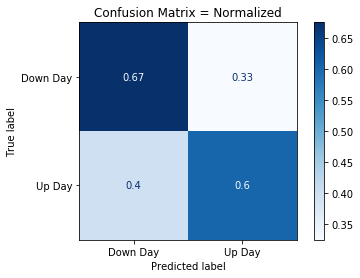

In [23]:
# Model evaluation: Confusion matrix

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

display(rf_matrix)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_first_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix = Normalized')
plt.show()